In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os, time, math, warnings
warnings.filterwarnings('ignore')
import polcal_lib as pln
import numpy as np
from matplotlib import pyplot as plt

### Generating a set of calibration units states
*cal_unit* takes as arguments: [alpha, delta, theta] where

-    alpha == off set of the polarizer(angle)
-    delta == retardance of retarder
-    theta == off set of the retarder 

In [2]:
cl = pln.cal_unit(0., 75., 0., angle_rot=None)
#result is a column vector!
print(cl)


[[0.5]
 [0.5]
 [0. ]
 [0. ]]


If you want to generate a full range of calibration states

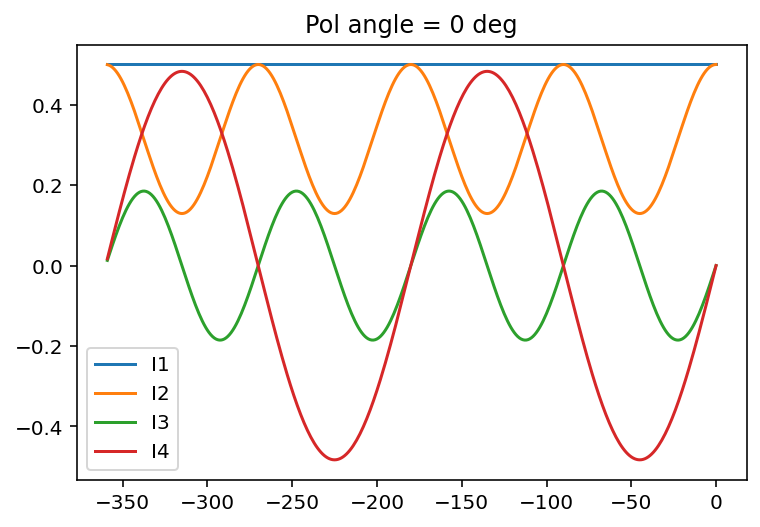

In [3]:
#generate the calibration states (input to instrument)
#def cal_unit(alpha, delta, theta, angle_rot=None):
    #theta = off set of the retarder
    #delta = retardance
    #alpha = off set of the polarizer(angle)
    #theta = np.arange(0, -360, -1)
theta = np.arange(0, -360, -1)
out = np.zeros((4,360))
for i in range(len(theta)):
    out[:,i] = pln.cal_unit(0.,75.,theta[i]).flatten()
plt.plot(theta, out[0, :], label = 'I1')
plt.plot(theta, out[1, :], label = 'I2')
plt.plot(theta, out[2, :], label = 'I3')
plt.plot(theta, out[3, :], label = 'I4')
plt.title('Pol angle = 0 deg')
plt.legend()
plt.show()


- Instrument model is in pol_model
- input is system parameters (see example below) and rotation angle) 

    #def pol_model(pardata=pardata,angle_rot=0):



In [4]:
pardata = {'delta1' : np.array([225, 225, 315, 315]),
           'delta2' : np.array([234, 125.26, 54.74, 305.26]),
           'theta1' : 0,
           'theta2' : 45,
           'pol_angle' : 0,
           'rot_inst' : 0}

mod_matrix = pln.instrument_model(pardata=pardata)
print(2.*mod_matrix)

[[ 1.00000000e+00 -8.20135435e-01 -1.11184406e-02 -5.72061403e-01]
 [ 1.00000000e+00  6.63500315e-05 -8.16474462e-01  5.77381545e-01]
 [ 1.00000000e+00  8.16474462e-01 -6.63500315e-05 -5.77381545e-01]
 [ 1.00000000e+00 -6.63500315e-05  8.16474462e-01  5.77381545e-01]]


We can see how the instrument modulates the PCU input

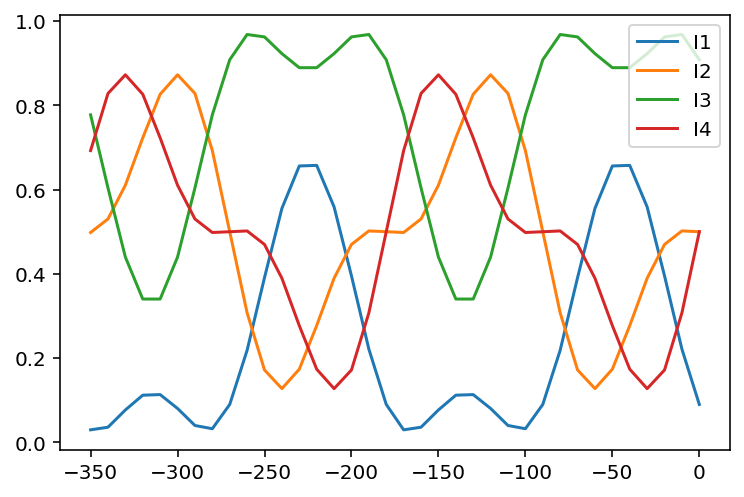

In [5]:
mod_matrix, response = pln.pol_cal_model(alpha=0, delta=75, theta=np.arange(0, -360, -10),pardata=pardata,plot=True)

Lets read some data and compare the output with the model

In [6]:
#leemos los datos
from scipy.io.idl import readsav
file = '../../../../PHI_POLCAL_revisited/datos_FDT_40D_J0.sav'
s = readsav(file)
data = s.data
data = np.einsum('klij->ijkl', data)
#norma = np.max(data[500:1500,500:1500,:,:])
#data = data/norma

In [7]:
read_signal = np.mean(data[1024-20:1024+20,1024-20:1024+20,:,:],axis=(0,1)) 
#normalize around the max:
norma = np.max(data[1024-20:1024+20,1024-20:1024+20,:,:])  
read_signal /= norma
np.savez('signa',read_signal)

In [57]:
pardata = {'delta1' : np.array([225, 225, 315, 315]),
           'delta2' : np.array([234, 125.26, 54.74, 305.26]),
           'theta1' : 0,
           'theta2' : 45,
           'pol_angle' : 0,
           'rot_inst' : 0}
theta = np.arange(0, -360, -10) - 0.631 - 5 #wave plate fast axis angle
'''
#theta = off set of the retarder
#delta = retardance
#alpha = off set of the polarizer(angle)
'''
#el modelo
mod_matrix, response = pln.pol_cal_model(alpha= - 5.76200, delta=75.52, theta=theta,pardata=pardata)

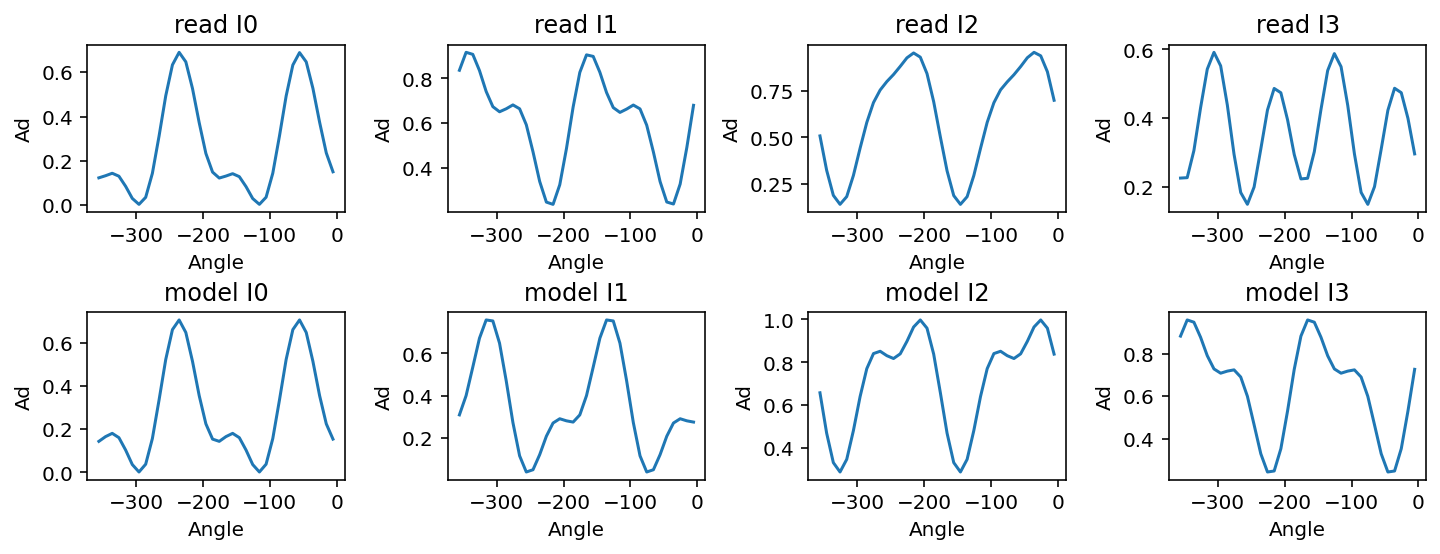

In [58]:
fig, maps = plt.subplots(2,4,figsize=(12,4))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i in range(4):
    maps[0,i].plot(theta, read_signal[:,i])
    #maps[0,i].xvline(theta, read_signal[:,i])
    maps[0,i].set_title('read I'+str(i))
    maps[0,i].set_ylabel('Ad')
    maps[0,i].set_xlabel('Angle')
for i in range(4):
    maps[1,i].plot(theta, response[:,i])
    maps[1,i].set_title('model I'+str(i))
    maps[1,i].set_ylabel('Ad')
    maps[1,i].set_xlabel('Angle')

In [10]:
import scipy.optimize as optimization

In [93]:
def fit_calib(x,y,plot=None,w_cut=1e-10):
    '''
    input:  calib states (angle,4), obs (angle)
    '''
    xc = np.matmul(x.T,x)
    xi = pln.svd_solve(xc, w_cut=w_cut)
    cf = np.matmul(xi,np.matmul(x.T,y))
    yfit = np.matmul(x,cf)
    cov = np.sqrt(np.sum((yfit - y)**2)/(len(y) - len(xc) + 1.0 ) * xc.diagonal() )
    if plot:
        plt.plot(y,'.')
        plt.plot(yfit,'-')
    return cf,yfit,cov

[[ 0.99631557 -0.68844999  0.36128807 -0.6149587 ]
 [ 1.00673858  0.41110225  0.74646711  0.54142761]
 [ 0.99565298  0.45121214 -0.36652174 -0.81385639]
 [ 1.00420479 -0.385837   -0.92277888  0.12951111]]


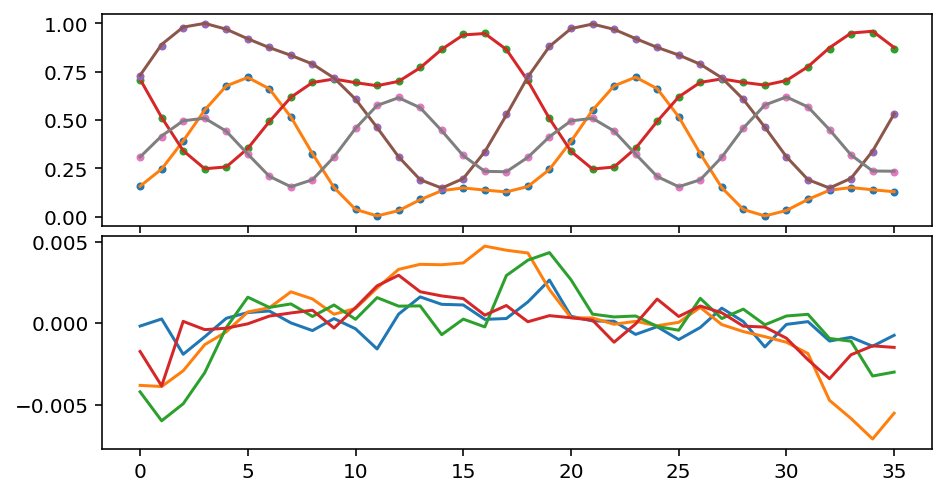

In [172]:
from matplotlib.gridspec import GridSpec

theta = np.arange(0, -360, -10) 
xdata = np.zeros((36, 4))
for i in range(len(theta)):
    xdata[i,:] = pln.cal_unit(0.305,75.442,theta[i],angle_rot=0).flatten()
ydata = np.copy(read_signal).astype(float)
modm = np.zeros((4,4))

fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

norm = np.max(ydata)
for i in range(4):
    modm[i,:],yfit,cov = fit_calib(xdata,ydata[:,i]/norm,w_cut=1e-20)
    ax1.plot(yfit,'.')
    ax1.plot(ydata[:,i]/norm,'-')
    ax2.plot(yfit - ydata[:,i]/norm)

print(modm)


In [150]:
# The function whose square is to be minimised.
# params ... list of parameters tuned to minimise function.
# Further arguments:
# xdata ... design matrix for a linear model.
# ydata ... observed data.
def func(params, xdata, ydata):
    theta = np.arange(0, -360, -10) + params[2]
    xdata = np.zeros((36, 4))
    for i in range(len(theta)):
        xdata[i,:] = pln.cal_unit(params[0],params[1],theta[i]).flatten()
    yfit = np.zeros((36, 4))
    for i in range(4):
        _,yfit[:,i],_ = fit_calib(xdata,ydata[:,i],w_cut=1e-20)
    return (yfit - ydata).flatten()

In [151]:

test = optimization.leastsq(func , [0.305,75.442,0.], args=(xdata, ydata/np.max(ydata)))



In [152]:
print(np.mod(test,180))

[array([158.73684583, 147.97805405, 158.42957515]) 1]


[[ 3.67971303 -1.25584328  3.61343609  1.12252954]
 [-0.63648236  3.98747627  1.29650897 -0.9883076 ]
 [-0.75754554  0.38656967 -2.83398519  1.48559253]
 [ 2.55587109 -4.49001615 -2.01446379 -0.23640599]]
[[ 3.04010766 -1.0375534   2.98535094  0.92741217]
 [-0.52584941  3.29437569  1.0711506  -0.8165206 ]
 [-0.62586946  0.31937638 -2.3413837   1.22736778]
 [ 2.11161121 -3.70956441 -1.66431098 -0.19531405]]


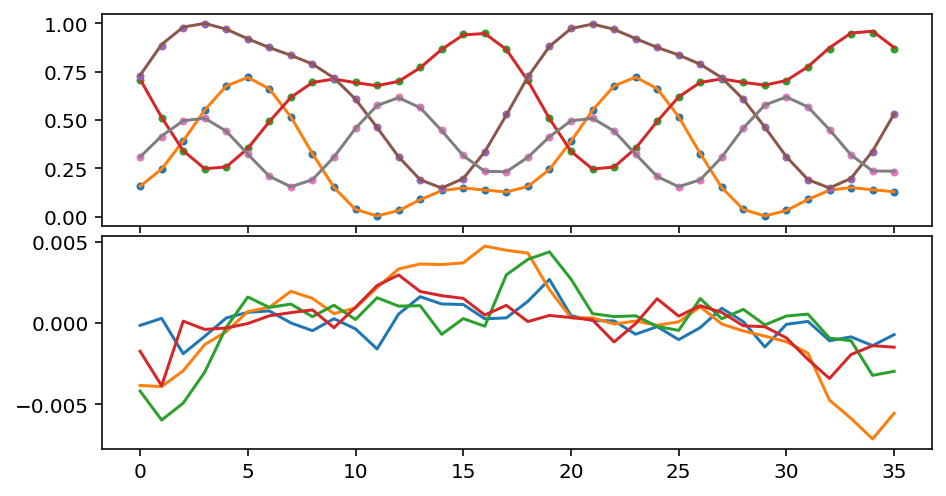

In [153]:
theta = np.arange(0, -360, -10) + test[0][2]
xdata = np.zeros((36, 4))
for i in range(len(theta)):
    xdata[i,:] = pln.cal_unit(test[0][0],test[0][1],theta[i]).flatten()
ydata = np.copy(read_signal).astype(float)
modm = np.zeros((4,4))

fig = plt.figure()
gs = GridSpec(2, 1,left=0.02, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

norm = np.max(ydata)
for i in range(4):
    modm[i,:],yfit,cov = fit_calib(xdata,ydata[:,i]/norm,w_cut=1e-20)
    ax1.plot(yfit,'.')
    ax1.plot(ydata[:,i]/norm,'-')
    ax2.plot(yfit - ydata[:,i]/norm)

print(modm)
print(modm/np.mean(modm[:,0]))